# Robust Pooling

We illustrate several robust pooling operations. Denote by $\phi$ the penalty function. Then robust pooling finds the solution to the optimization problem

$$
y \in \text{arg min}_u \sum_{i=1}^{n} \phi(u - x_i; \alpha)
$$

where $\alpha$ is a parameter of the penalty function.

In [1]:
# define various penalty functions

import numpy as np

phi = {
    'Quadratic':    lambda z, alpha: 0.5 * np.power(z, 2.0),
    'Huber':        lambda z, alpha: np.where(np.abs(z) <= alpha, 0.5 * np.power(z, 2.0), alpha * np.abs(z) - 0.5 * alpha * alpha),
    'Pseudo-Huber': lambda z, alpha: np.power(alpha, 2.0) * (np.sqrt(1.0 + np.power(z, 2.0) / np.power(alpha, 2.0)) - 1.0),
    'Welsch':       lambda z, alpha: 1.0 - np.exp(-0.5 * np.power(z / alpha, 2.0)),
    'Trunc. Quad.': lambda z, alpha: np.minimum(0.5 * np.power(z, 2.0), 0.5 * alpha * alpha)
}

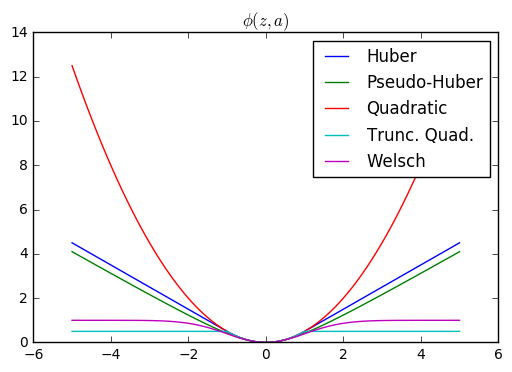

In [2]:
# plot the penalty functions

import matplotlib.pyplot as plt
%matplotlib inline

alpha = 1.0
z = np.linspace(-5.0, 5.0, num=101)

for name in sorted(phi.keys()):
    plt.plot(z, phi[name](z, alpha))

plt.title("$\phi(z, a)$")
plt.legend(sorted(phi.keys()))
plt.show()

By plotting the sum of two penalty functions centered at $x_1 = -2\alpha$ and $x_2 = 2\alpha$, respectively, we can observe some of their properties: such as the convexity of Huber, the strong convexity of pseudo-Huber and the non-convexity of Welsch.

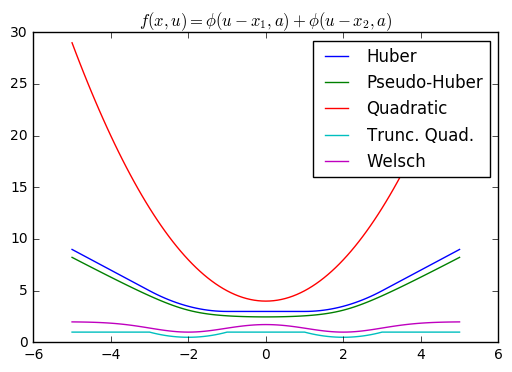

In [3]:
# plot the sum of two penalty functions

alpha = 1.0
delta = 2.0 * alpha
u = np.linspace(-5.0, 5.0, num=101)

for name in sorted(phi.keys()):
    plt.plot(u, phi[name](u - delta, alpha) + phi[name](u + delta, alpha))

plt.title("$f(x, u) = \phi(u - x_1, a) + \phi(u - x_2, a)$")
plt.legend(sorted(phi.keys()))
plt.show()

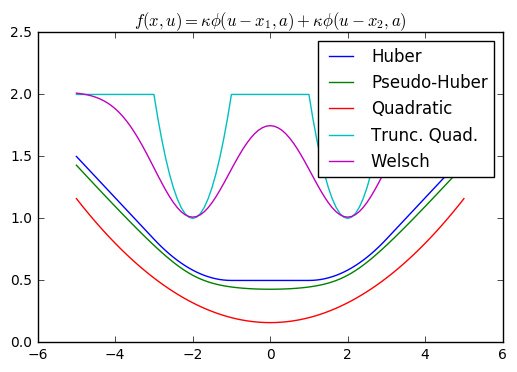

In [4]:
# plot the sum of two penalty functions scaled

for name in sorted(phi.keys()):
    f = phi[name](u - delta, alpha) + phi[name](u + delta, alpha)
    plt.plot(u, f / (np.max(f) - np.min(f)))

plt.title("$f(x, u) = \kappa \phi(u - x_1, a) + \kappa \phi(u - x_2, a)$")
plt.legend(sorted(phi.keys()))
plt.show()

We now explore how the solutions of the sum of two penalty functions vary as a function of its inputs. We fix $x_1$ to zero and varying $x_2$. Our objective (with $\alpha = 1$) is
$$
f(x, u) = \phi(u) + \phi(u - x)
$$
for scalar $x$ and $u$.

As we vary $x$ we see that the non-convex penalty functions can produce multiple isolated solutions, while the strongly convex quadratic and pseudo-Huber always produce a single solution. Note, however, that for a large number of points (sum of $n >> 2$ penalty functions) the effect from changing a single point would not be as pronounced as we demonstrate here for just two points.

In [5]:
# prepare data for animation and plots

def find_local_minima(v):
    """Finds the local minima of a one-dimensional curve and returns their index. In the
    case of a plateau (such as for Huber) returns the boundary points of the plateau."""
    return [i for i in range(1, len(v)-1) if ((v[i] < v[i-1]) and (v[i] <= v[i+1])) or ((v[i] <= v[i-1]) and (v[i] < v[i+1]))]


x = np.linspace(-4.0, 4.0, num=100)
u = np.linspace(-5.0, 5.0, num=501)
y = {}
for name in sorted(phi.keys()):
    y[name] = [[] for xi in x]

for i in range(len(x)):
    for name in sorted(phi.keys()):
        # find (global) minimia of objective function
        f = phi[name](u, 1.0) + phi[name](u - x[i], 1.0)
        f_min = np.min(f)
        y[name][i] = [j for j in find_local_minima(f) if f[j] <= f_min + 1.0e-3]

In [6]:
# animate solution for sum of two penalty functions

from matplotlib import animation
from IPython.display import HTML


def animate(fnum, u, x, y):
    plt.clf()

    for a in ax:
        a.clear()
        
    for name in sorted(phi.keys()):
        # plot the (normalized) objective
        f = phi[name](u, 1.0) + phi[name](u - x[fnum], 1.0)
        f = f / np.max(f)
        p = ax[0].plot(u, f)

        # indicate minima
        for i in y[name][fnum]:
            ax[0].plot([u[i], u[i]], [-0.1, f[i]], color=p[0].get_color(), ls='--')
        
        # plot y (global minima) as a function of x
        y_min = [min(u[i]) for i in y[name][:fnum+1]]
        y_max = [max(u[i]) for i in y[name][:fnum+1]]
        
        ax[1].plot(x[:fnum+1], y_min, color=p[0].get_color())
        ax[1].plot(x[:fnum+1], y_max, color=p[0].get_color())
        
    ax[0].set_xlim(u[0], u[-1]); ax[0].set_ylim(-0.1, 1.0)
    ax[0].set_xlabel(r"$u$"); ax[0].set_ylabel(r"$f$ (scaled)")
    ax[0].set_title("Objective")
    
    ax[1].set_xlim(x[0], x[-1]); ax[1].set_ylim(-4.0, 4.0)
    ax[1].set_xlabel(r"$x$"); ax[1].set_ylabel(r"$y$")
    ax[1].set_title("Solution")

    return ax


fig = plt.figure()
ax = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
ani = animation.FuncAnimation(fig, animate, fargs=(u, x, y), interval=100, frames=len(x), blit=False, repeat=False)
plt.close(fig)

HTML(ani.to_html5_video())

We now plot the solution sets separately for each penalty function.

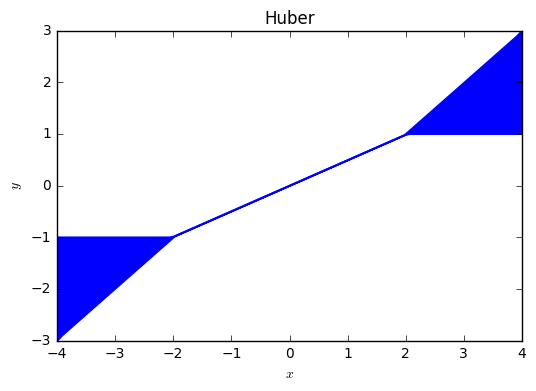

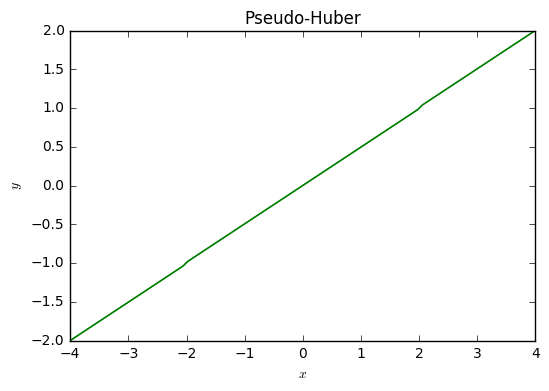

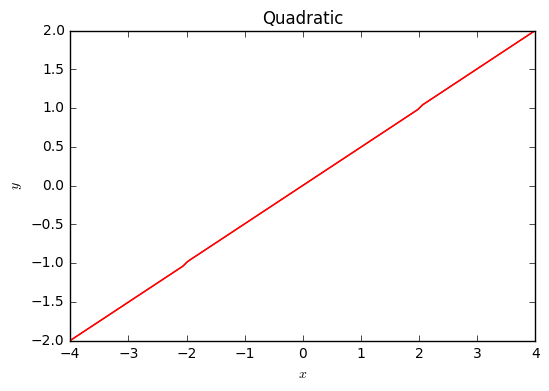

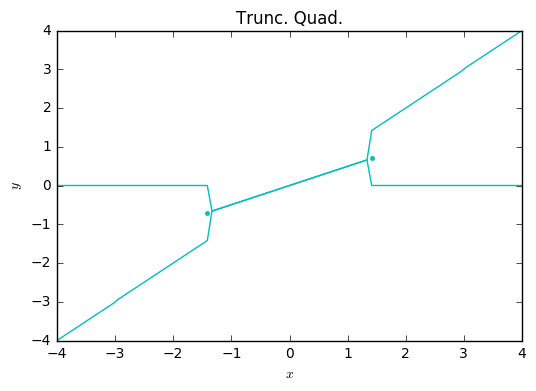

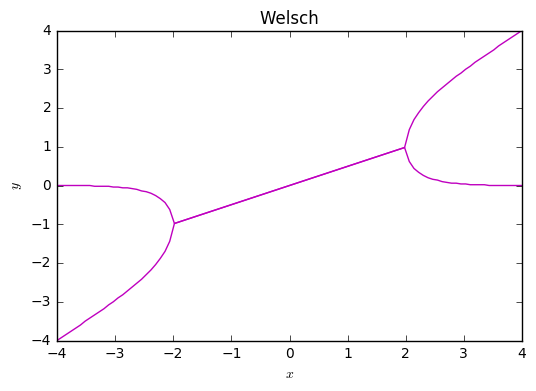

In [7]:
cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for indx, name in enumerate(sorted(phi.keys())):
    y_min = [min(u[i]) for i in y[name]]
    y_max = [max(u[i]) for i in y[name]]

    fig = plt.figure()
    plt.plot(x, y_min, color=cm[indx % len(cm)])
    plt.plot(x, y_max, color=cm[indx % len(cm)])
    for i in range(len(x)):
        if len(y[name][i]) > 2:
            for uj in [u[jy] for jy in y[name][i] if ((u[jy] != y_min[i]) and (u[jy] != y_max[i]))]:
                plt.plot(x[i], uj, color=cm[indx % len(cm)], marker='.')
            
    if name == "Huber":
        plt.fill_between(x, y_max, y_min, color=cm[indx % len(cm)])
    
    plt.xlabel(r"$x$"); plt.ylabel(r"$y$"); plt.title(name)
    
plt.show()